## Import Packages and Data

In [65]:
#Import Package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance

In [66]:
#Import datasets
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
data_holidays = pd.read_csv('holidays_events.csv')
data_oil = pd.read_csv('oil.csv')
data_stores = pd.read_csv('stores.csv')

## Check whether there are any NaN in the datasets

In [67]:
data_train.isnull().any()

id             False
date           False
store_nbr      False
family         False
sales          False
onpromotion    False
dtype: bool

In [68]:
data_test.isnull().any()

id             False
date           False
store_nbr      False
family         False
onpromotion    False
dtype: bool

In [69]:
data_holidays.isnull().any()

date           False
type           False
locale         False
locale_name    False
description    False
transferred    False
dtype: bool

In [70]:
data_oil.isnull().any()

date          False
dcoilwtico     True
dtype: bool

In [71]:
#Fill the NaN with lastest price
data_oil_new = pd.DataFrame()
data_oil_new = data_oil
for i in range(len(data_oil_new)):
    if data_oil_new.iloc[i][1] > 0:
        pass
    elif i != 0:
        data_oil_new['dcoilwtico'][i] = data_oil_new['dcoilwtico'][i-1]
data_oil_new['dcoilwtico'][0] = data_oil_new['dcoilwtico'][1]

C:\Users\gbphw\AppData\Local\Temp\ipykernel_10640\3181917605.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_oil_new['dcoilwtico'][i] = data_oil_new['dcoilwtico'][i-1]
C:\Users\gbphw\AppData\Local\Temp\ipykernel_10640\3181917605.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_oil_new['dcoilwtico'][0] = data_oil_new['dcoilwtico'][1]


In [72]:
data_oil_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1218 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [73]:
data_stores.isnull().any()

store_nbr    False
city         False
state        False
type         False
cluster      False
dtype: bool

In [74]:
data_holidays["locale"].value_counts()

National    174
Local       152
Regional     24
Name: locale, dtype: int64

## Merging Data into a Table

In [75]:
df_train = data_train
df_train = df_train.merge(data_oil_new, how='left', on = 'date')
data_stores['country'] = 'Ecuador' 
df_train = df_train.merge(data_stores, how='left', on = 'store_nbr')

In [76]:
df_test = data_test
df_test = df_test.merge(data_oil_new, how='left', on = 'date')
df_test = df_test.merge(data_stores, how='left', on = 'store_nbr')

In [77]:
data_holidays_country = data_holidays.rename({"locale_name":"country"}, axis='columns')
df_train = df_train.merge(data_holidays_country, how='left', on = ['date', 'country'] )

In [78]:
df_test = df_test.merge(data_holidays_country, how='left', on = ['date', 'country'] )

## Transforming Data into the Right Format

In [15]:
df_train = df_train.drop(['country', 'type_y', 'description','transferred'], axis=1)
df_train['national_holiday'] = pd.get_dummies(df_train['locale'])
df_train = df_train.drop(['locale'], axis=1)

In [16]:
df_test = df_test.drop(['country', 'type_y', 'description','transferred'], axis=1)
df_test['national_holiday'] = 0
df_test = df_test.drop(['locale'], axis=1)

In [17]:
df_train = df_train.rename({"type_x" : "store_type"}, axis = 'columns')
df_test = df_test.rename({"type_x" : "store_type"}, axis = 'columns')

In [18]:
data_holidays_region = data_holidays.rename({"locale_name":"state"}, axis='columns')
df_train = df_train.merge(data_holidays_region, how='left', on = ['date', 'state'] )

In [19]:
df_test = df_test.merge(data_holidays_region, how='left', on = ['date', 'state'] )

In [20]:
df_train = df_train.drop(['type', 'description','transferred'], axis=1)
df_train['region_holiday'] = df_train['locale']=='Regional'
df_train = df_train.drop(['locale'], axis=1)

In [21]:
df_test = df_test.drop(['type', 'description','transferred'], axis=1)
df_test['region_holiday'] = df_test['locale']=='Regional'
df_test = df_test.drop(['locale'], axis=1)

In [22]:
data_holidays_city = data_holidays.rename({"locale_name":"city"}, axis='columns')
df_train = df_train.merge(data_holidays_city, how='left', on = ['date', 'city'] )
df_test = df_test.merge(data_holidays_city, how='left', on = ['date', 'city'] )

In [23]:
df_train = df_train.drop(['type', 'description','transferred'], axis=1)
df_train['city_holiday'] = df_train['locale']=='Local'
df_train = df_train.drop(['locale'], axis=1)

In [24]:
df_test = df_test.drop(['type', 'description','transferred'], axis=1)
df_test['city_holiday'] = df_test['locale']=='Local'
df_test = df_test.drop(['locale'], axis=1)

In [25]:
df_train = df_train.replace(to_replace = False, value =0)
df_train = df_train.replace(to_replace = True, value =1)

In [26]:
df_test = df_test.replace(to_replace = False, value =0)
df_test = df_test.replace(to_replace = True, value =1)

In [27]:
#df_train['holidays'] = (df_train["national_holiday"]>0) | (df_train["region_holiday"]>0) | (df_train["city_holiday"]>0)
#df_test['holidays'] = (df_test["national_holiday"]>0) | (df_test["region_holiday"]>0) | (df_test["city_holiday"]>0)

In [28]:
#df_train = df_train.replace(to_replace = False, value =0)
#df_train = df_train.replace(to_replace = True, value =1)
#df_test = df_test.replace(to_replace = False, value =0)
#df_test = df_test.replace(to_replace = True, value =1)

In [29]:
df_train

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,store_type,cluster,national_holiday,region_holiday,city_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,93.14,Quito,Pichincha,D,13,1,0,0
1,1,2013-01-01,1,BABY CARE,0.000,0,93.14,Quito,Pichincha,D,13,1,0,0
2,2,2013-01-01,1,BEAUTY,0.000,0,93.14,Quito,Pichincha,D,13,1,0,0
3,3,2013-01-01,1,BEVERAGES,0.000,0,93.14,Quito,Pichincha,D,13,1,0,0
4,4,2013-01-01,1,BOOKS,0.000,0,93.14,Quito,Pichincha,D,13,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008275,3000883,2017-08-15,9,POULTRY,438.133,0,47.57,Quito,Pichincha,B,6,0,0,0
3008276,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,Quito,Pichincha,B,6,0,0,0
3008277,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,Quito,Pichincha,B,6,0,0,0
3008278,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,Quito,Pichincha,B,6,0,0,0


Focus on data after 2017-01-01

In [30]:
df_train = df_train[df_train['date']>"2016-12-31"]

In [31]:
#Create month, day columns for train set
month_train=[]
day_train=[]
for i in range(len(df_train)):
    month_train.append(df_train.iloc[i][1][5:7])
    day_train.append(df_train.iloc[i][1][8:10])
df_train['month'] = month_train
df_train['day'] = day_train

C:\Users\gbphw\AppData\Local\Temp\ipykernel_10640\1865844059.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['month'] = month_train
C:\Users\gbphw\AppData\Local\Temp\ipykernel_10640\1865844059.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['day'] = day_train


In [32]:
#Create month, day columns for test set
month_test=[]
day_test=[]
for i in range(len(df_test)):
    month_test.append(df_test.iloc[i][1][5:7])
    day_test.append(df_test.iloc[i][1][8:10])
df_test['month'] = month_test
df_test['day'] = day_test

In [33]:
df_train

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,store_type,cluster,national_holiday,region_holiday,city_holiday,month,day
2603766,2596374,2017-01-01,1,AUTOMOTIVE,0.000,0,NaN,Quito,Pichincha,D,13,1,0,0,01,01
2603767,2596375,2017-01-01,1,BABY CARE,0.000,0,NaN,Quito,Pichincha,D,13,1,0,0,01,01
2603768,2596376,2017-01-01,1,BEAUTY,0.000,0,NaN,Quito,Pichincha,D,13,1,0,0,01,01
2603769,2596377,2017-01-01,1,BEVERAGES,0.000,0,NaN,Quito,Pichincha,D,13,1,0,0,01,01
2603770,2596378,2017-01-01,1,BOOKS,0.000,0,NaN,Quito,Pichincha,D,13,1,0,0,01,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008275,3000883,2017-08-15,9,POULTRY,438.133,0,47.57,Quito,Pichincha,B,6,0,0,0,08,15
3008276,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,Quito,Pichincha,B,6,0,0,0,08,15
3008277,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,Quito,Pichincha,B,6,0,0,0,08,15
3008278,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,Quito,Pichincha,B,6,0,0,0,08,15


In [34]:
df_test

,id,date,store_nbr,family,onpromotion,dcoilwtico,city,state,store_type,cluster,national_holiday,region_holiday,city_holiday,month,day
0,3000888,2017-08-16,1,AUTOMOTIVE,0,46.80,Quito,Pichincha,D,13,0,0,0,08,16
1,3000889,2017-08-16,1,BABY CARE,0,46.80,Quito,Pichincha,D,13,0,0,0,08,16
2,3000890,2017-08-16,1,BEAUTY,2,46.80,Quito,Pichincha,D,13,0,0,0,08,16
3,3000891,2017-08-16,1,BEVERAGES,20,46.80,Quito,Pichincha,D,13,0,0,0,08,16
4,3000892,2017-08-16,1,BOOKS,0,46.80,Quito,Pichincha,D,13,0,0,0,08,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,47.26,Quito,Pichincha,B,6,0,0,0,08,31
28508,3029396,2017-08-31,9,PREPARED FOODS,0,47.26,Quito,Pichincha,B,6,0,0,0,08,31
28509,3029397,2017-08-31,9,PRODUCE,1,47.26,Quito,Pichincha,B,6,0,0,0,08,31
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,47.26,Quito,Pichincha,B,6,0,0,0,08,31


In [35]:
#Split train set into train set and validation set
data_train = df_train[df_train['date']<="2017-07-15"]
data_val = df_train[df_train['date']>"2017-07-15"]
data_test = df_test

## Creating an Additional Column - Weekday

In [36]:
#Create weekday column for train set
train_date = []
for j in range(len(data_train)):
    train_date.append(datetime.strptime(data_train.iloc[j][1],"%Y-%m-%d"))
s_train_date = pd.Series(train_date)
s_train_date = s_train_date.dt.weekday
s_train_date = s_train_date.tolist()
data_train['weekday'] = s_train_date

C:\Users\gbphw\AppData\Local\Temp\ipykernel_10640\2011225616.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['weekday'] = s_train_date


In [37]:
#Create weekday column for validation set
val_date = []
for j in range(len(data_val)):
    val_date.append(datetime.strptime(data_val.iloc[j][1],"%Y-%m-%d"))
s_val_date = pd.Series(val_date)
s_val_date = s_val_date.dt.weekday
s_val_date = s_val_date.tolist()
data_val['weekday'] = s_val_date

C:\Users\gbphw\AppData\Local\Temp\ipykernel_10640\236884441.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val['weekday'] = s_val_date


In [38]:
#Create weekday column for test set
test_date = []
for j in range(len(data_test)):
    test_date.append(datetime.strptime(data_test.iloc[j][1],"%Y-%m-%d"))
s_test_date = pd.Series(test_date)
s_test_date = s_test_date.dt.weekday
s_test_date = s_test_date.tolist()
data_test['weekday'] = s_test_date

In [39]:
#Drop duplicate columns
data_train = data_train.drop(['id'], axis=1)
data_val = data_val.drop(['id'], axis=1)
data_test = data_test.drop(['id'], axis=1)

In [40]:
X_train = data_train.drop(['sales'],axis=1)
y_train = data_train['sales']
X_val = data_val.drop(['sales'],axis=1)
y_val = data_val['sales']

In [41]:
X_train.isnull().any()

date                False
store_nbr           False
family              False
onpromotion         False
dcoilwtico           True
city                False
state               False
store_type          False
cluster             False
national_holiday    False
region_holiday      False
city_holiday        False
month               False
day                 False
weekday             False
dtype: bool

## Cleaining Oil Data

In [42]:
#Use average oil price to fill oil na in train set
train_oil_new = pd.DataFrame()
train_oil_new['date'] = data_train['date']
train_oil_new = train_oil_new.merge(data_oil_new, how='left', on = 'date')
train_oil_new['month'] = train_oil_new['date'].map(lambda x: int(x.replace('-', '')[:6]))
train_oil_new['month_avg'] = train_oil_new.groupby('month')['dcoilwtico'].transform('mean')
train_oil_new['tmp'] = train_oil_new['dcoilwtico'].map(np.isnan)
train_oil_new['month_avg'] = train_oil_new['tmp'] * train_oil_new['month_avg']
train_oil_new['dcoilwtico'].fillna(0, inplace=True)
train_oil_new['oil'] = train_oil_new['dcoilwtico'] + train_oil_new['month_avg']
train_oil_new = train_oil_new.drop(['month', 'month_avg', 'tmp','dcoilwtico'], axis=1)
train_oil = train_oil_new['oil'].tolist()
X_train['oil'] = train_oil

In [43]:
#Use average oil price to fill oil na in validation set
val_oil_new = pd.DataFrame()
val_oil_new['date'] = data_val['date']
val_oil_new = val_oil_new.merge(data_oil_new, how='left', on = 'date')
val_oil_new['month'] = val_oil_new['date'].map(lambda x: int(x.replace('-', '')[:6]))
val_oil_new['month_avg'] = val_oil_new.groupby('month')['dcoilwtico'].transform('mean')
val_oil_new['tmp'] = val_oil_new['dcoilwtico'].map(np.isnan)
val_oil_new['month_avg'] = val_oil_new['tmp'] * val_oil_new['month_avg']
val_oil_new['dcoilwtico'].fillna(0, inplace=True)
val_oil_new['oil'] = val_oil_new['dcoilwtico'] + val_oil_new['month_avg']
val_oil_new = val_oil_new.drop(['month', 'month_avg', 'tmp','dcoilwtico'], axis=1)
val_oil = val_oil_new['oil'].tolist()
X_val['oil'] = val_oil

In [44]:
#Use average oil price to fill oil na in test set
test_oil_new = pd.DataFrame()
test_oil_new['date'] = data_test['date']
test_oil_new = test_oil_new.merge(data_oil_new, how='left', on = 'date')
test_oil_new['month'] = test_oil_new['date'].map(lambda x: int(x.replace('-', '')[:6]))
test_oil_new['month_avg'] = test_oil_new.groupby('month')['dcoilwtico'].transform('mean')
test_oil_new['tmp'] = test_oil_new['dcoilwtico'].map(np.isnan)
test_oil_new['month_avg'] = test_oil_new['tmp'] * test_oil_new['month_avg']
test_oil_new['dcoilwtico'].fillna(0, inplace=True)
test_oil_new['oil'] = test_oil_new['dcoilwtico'] + test_oil_new['month_avg']
test_oil_new = test_oil_new.drop(['month', 'month_avg', 'tmp','dcoilwtico'], axis=1)
test_oil = test_oil_new['oil'].tolist()
data_test['oil'] = test_oil

In [45]:
X_train = X_train.drop(['dcoilwtico', 'date'], axis=1)
X_val = X_val.drop(['dcoilwtico', 'date'], axis=1)
data_test = data_test.drop(['dcoilwtico', 'date'], axis=1)

## Transforming Categorical Data

In [46]:
#Apply labelencoder to deal with the categorize factors
cat_features = ['family', 'store_nbr', 'city', 'state', 'store_type', 'cluster']
for col in cat_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_val[col] = le.fit_transform(X_val[col])
    data_test[col] = le.transform(data_test[col])

In [47]:
train_test_data = pd.concat([X_train,X_val])
train_test_data = pd.concat([train_test_data,data_test])

In [48]:
train_test_data

,store_nbr,family,onpromotion,city,state,store_type,cluster,national_holiday,region_holiday,city_holiday,month,day,weekday,oil
2603766,0,0,0,18,12,3,12,1,0,0,01,01,6,52.554091
2603767,0,1,0,18,12,3,12,1,0,0,01,01,6,52.554091
2603768,0,2,0,18,12,3,12,1,0,0,01,01,6,52.554091
2603769,0,3,0,18,12,3,12,1,0,0,01,01,6,52.554091
2603770,0,4,0,18,12,3,12,1,0,0,01,01,6,52.554091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,8,28,1,18,12,1,5,0,0,0,08,31,3,47.260000
28508,8,29,0,18,12,1,5,0,0,0,08,31,3,47.260000
28509,8,30,1,18,12,1,5,0,0,0,08,31,3,47.260000
28510,8,31,9,18,12,1,5,0,0,0,08,31,3,47.260000


In [49]:
train_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433026 entries, 2603766 to 28511
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   store_nbr         433026 non-null  int64  
 1   family            433026 non-null  int32  
 2   onpromotion       433026 non-null  int64  
 3   city              433026 non-null  int32  
 4   state             433026 non-null  int32  
 5   store_type        433026 non-null  int32  
 6   cluster           433026 non-null  int64  
 7   national_holiday  433026 non-null  int64  
 8   region_holiday    433026 non-null  int64  
 9   city_holiday      433026 non-null  int64  
 10  month             433026 non-null  object 
 11  day               433026 non-null  object 
 12  weekday           433026 non-null  int64  
 13  oil               433026 non-null  float64
dtypes: float64(1), int32(4), int64(7), object(2)
memory usage: 42.9+ MB


## Transforming Date Data into Dummies Variables

In [50]:
#Create weekday, month, day dummy variables
#weekday_dummy = pd.get_dummies(train_test_data['weekday'], prefix ='weekday')
#month_dummy = pd.get_dummies(train_test_data['month'], prefix ='month')
#day_dummy = pd.get_dummies(train_test_data['day'], prefix ='day')

In [51]:
#train_test_data = pd.concat([train_test_data,weekday_dummy], axis =1)
#train_test_data = pd.concat([train_test_data,month_dummy], axis =1)
#train_test_data = pd.concat([train_test_data,day_dummy], axis =1)
#train_test_data = train_test_data.drop(['month', 'day','weekday'], axis=1)
train_test_data[["month","day"]] = train_test_data[["month","day"]].astype('int32')

In [52]:
train_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433026 entries, 2603766 to 28511
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   store_nbr         433026 non-null  int64  
 1   family            433026 non-null  int32  
 2   onpromotion       433026 non-null  int64  
 3   city              433026 non-null  int32  
 4   state             433026 non-null  int32  
 5   store_type        433026 non-null  int32  
 6   cluster           433026 non-null  int64  
 7   national_holiday  433026 non-null  int64  
 8   region_holiday    433026 non-null  int64  
 9   city_holiday      433026 non-null  int64  
 10  month             433026 non-null  int32  
 11  day               433026 non-null  int32  
 12  weekday           433026 non-null  int64  
 13  oil               433026 non-null  float64
dtypes: float64(1), int32(6), int64(7)
memory usage: 39.6 MB


In [53]:
train_test_data

,store_nbr,family,onpromotion,city,state,store_type,cluster,national_holiday,region_holiday,city_holiday,month,day,weekday,oil
2603766,0,0,0,18,12,3,12,1,0,0,1,1,6,52.554091
2603767,0,1,0,18,12,3,12,1,0,0,1,1,6,52.554091
2603768,0,2,0,18,12,3,12,1,0,0,1,1,6,52.554091
2603769,0,3,0,18,12,3,12,1,0,0,1,1,6,52.554091
2603770,0,4,0,18,12,3,12,1,0,0,1,1,6,52.554091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,8,28,1,18,12,1,5,0,0,0,8,31,3,47.260000
28508,8,29,0,18,12,1,5,0,0,0,8,31,3,47.260000
28509,8,30,1,18,12,1,5,0,0,0,8,31,3,47.260000
28510,8,31,9,18,12,1,5,0,0,0,8,31,3,47.260000


In [54]:
#Standardize the oil price 
ooil = train_test_data['oil'].tolist()
mean_oil = np.mean(ooil)
std_oil = np.std(ooil)
for i in range(len(ooil)):
    ooil[i] = (ooil[i]-mean_oil)/std_oil
train_test_data['oil'] = ooil

In [55]:
#scaler = MinMaxScaler()
#scaler.fit(train_test_data)
#train_test_data['oil'] = scaler.transform(train_test_data['oil'])

In [56]:
#Split dataset into train, validation, and test sets
X_train = train_test_data[:len(X_train)]
X_val = train_test_data[len(X_train):len(X_train)+len(X_val)]
X_test = train_test_data[len(X_train)+len(X_val):]

In [57]:
#Apply log to transfer the sales
y_train = np.log(y_train+1) 
y_val = np.log(y_val+1)

## Building model

In [58]:
#Model XGBOOST
xgbr = xgb.XGBRegressor(max_depth =11, n_estimators =10000, learning_rate =0.01, subsample =0.99, reg_alpha =10, reg_lambda=0.2, colsample_bytree=0.8)
xgbr.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)], eval_metric = 'rmse')

[0]	validation_0-rmse:3.95408	validation_1-rmse:3.97677


C:\Users\gbphw\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:3.91577	validation_1-rmse:3.93839
[2]	validation_0-rmse:3.87786	validation_1-rmse:3.90041
[3]	validation_0-rmse:3.84029	validation_1-rmse:3.86253
[4]	validation_0-rmse:3.80314	validation_1-rmse:3.82542
[5]	validation_0-rmse:3.76642	validation_1-rmse:3.78865
[6]	validation_0-rmse:3.72995	validation_1-rmse:3.75189
[7]	validation_0-rmse:3.69801	validation_1-rmse:3.72101
[8]	validation_0-rmse:3.66644	validation_1-rmse:3.69056
[9]	validation_0-rmse:3.63100	validation_1-rmse:3.65479
[10]	validation_0-rmse:3.60009	validation_1-rmse:3.62495
[11]	validation_0-rmse:3.56535	validation_1-rmse:3.59006
[12]	validation_0-rmse:3.53101	validation_1-rmse:3.55562
[13]	validation_0-rmse:3.49702	validation_1-rmse:3.52154
[14]	validation_0-rmse:3.46336	validation_1-rmse:3.48770
[15]	validation_0-rmse:3.43002	validation_1-rmse:3.45425
[16]	validation_0-rmse:3.39709	validation_1-rmse:3.42119
[17]	validation_0-rmse:3.36840	validation_1-rmse:3.39346
[18]	validation_0-rmse:3.33607	validatio

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Generating Predictions

In [59]:
#Predict test set
y_pre_xgbr = xgbr.predict(X_test)

In [60]:
#Sales must >= 0
y_pre_xgbr = np.expm1(y_pre_xgbr)
for i in range(len(y_pre_xgbr)):
    if y_pre_xgbr[i] < 0:
        y_pre_xgbr[i] =0

In [61]:
df_describe = pd.DataFrame(y_pre_xgbr)
df_describe.describe()

,0
count,28512.000000
mean,433.062958
std,1180.941040
min,0.000000
25%,3.795042
50%,27.314172
75%,250.367561
max,14989.106445


In [62]:
#Create the outcome file for the competition
outcome = pd.DataFrame()
outcome["id"] = df_test.iloc[:,0]
outcome["sales"] = y_pre_xgbr
outcome

,id,sales
0,3000888,3.557967
1,3000889,0.116868
2,3000890,5.851001
3,3000891,1888.924194
4,3000892,0.419943
...,...,...
28507,3029395,369.402893
28508,3029396,100.845741
28509,3029397,1226.534424
28510,3029398,44.101589


In [63]:
outcome.to_csv('Sales_predict.csv', index=False)

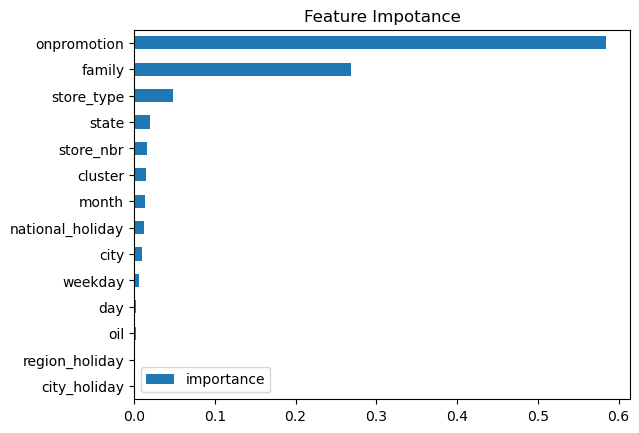

In [64]:
fi = pd.DataFrame(data = xgbr.feature_importances_, index = xgbr.feature_names_in_,columns=["importance"])
fi.sort_values("importance").plot(kind="barh", title="Feature Impotance")
plt.show()